In [1]:
import numpy as np
import pandas as pd
import os, re, math, platform
from pathlib import Path
import matplotlib.pyplot as plt
import json
import joblib
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, auc, fbeta_score
from imblearn.metrics import geometric_mean_score
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier 
from xgboost import plot_importance
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis as PA
from modlamp.descriptors import PeptideDescriptor, GlobalDescriptor
from matplotlib import pyplot
from sklearn.metrics import matthews_corrcoef, confusion_matrix,precision_recall_curve, roc_curve, auc, fbeta_score,roc_auc_score
from fea_extract import read_fasta,insert_AAC,insert_DPC,insert_CKSAAGP,insert_CTD,insert_PAAC,insert_AAI,insert_GTPC,insert_QSO,insert_AAE,insert_PSAAC,insert_word2int,insert_ASDC
import warnings 
from collections import Counter
from tools import cv,evaluate, pro_data
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.combine import SMOTEENN
warnings.filterwarnings('ignore')
seed=10

#### 处理数据
导入数据，对数据进行编码

In [52]:
X_train = pd.read_csv('data/train/X_train_norm.csv').to_numpy()
X_test = pd.read_csv('data/test/X_test_norm.csv').to_numpy()
y_train = pd.read_csv('data/train/y_train.csv').to_numpy()
y_test = pd.read_csv('data/test/y_test.csv').to_numpy()

#### 进行不平衡处理

In [3]:
smte = SMOTEENN(random_state=10)
X_train_resampled ,y_train_resampled = smte.fit_sample(X_train,y_train)

In [13]:
y_train_resampled1= y_train_resampled.reshape(2576,1)

In [159]:
X_train_resampled = pd.DataFrame(X_train_resampled,columns=feature_name1)
y_train_resampled1 = pd.DataFrame(y_train_resampled1,columns=['label'])

In [162]:
X_ = pd.concat([X_train_resampled,y_train_resampled1],axis=1)
X_.to_csv('data/process_X.csv',index = False)

In [4]:
import numpy as np
import pandas as pd
import math

def read_csv(filecsv):
    dataset=pd.read_csv(filecsv,engine='python').dropna(axis=1)
    features_name = dataset.columns.values.tolist()
    dataset=np.array(dataset)

    X=dataset[:,1:]
    y=dataset[:,0]
    return(X,y,features_name)

def calcE(X,coli,colj):
    # sum=0
    # for i in range(len(X)):
    #
    #      sum+=(X[i,coli]-X[i,colj])*(X[i,coli]-X[i,colj])
    sum = np.sum((X[:,coli]-X[:,colj])**2)


    return math.sqrt(sum)
def Euclidean(X,n):

    Euclideandata=np.zeros([n,n])

    for i in range(n):
        for j in range(n):
            Euclideandata[i,j]=calcE(X,i,j)
            Euclideandata[j,i]=Euclideandata[i,j]
    Euclidean_distance=[]

    for i in range(n):
        sum = np.sum(Euclideandata[i,:])
        Euclidean_distance.append(sum/n)

    return Euclidean_distance
def varience(data,avg1,col1,avg2,col2):

    return np.average((data[:,col1]-avg1)*(data[:,col2]-avg2))

def Person(X,y,n):
    feaNum=n
    #label_num=len(y[0,:])
    label_num=1
    PersonData=np.zeros([n])
    for i in range(feaNum):
        for j in range(feaNum,feaNum+label_num):
            #print('. ', end='')
            average1 = np.average(X[:,i])
            average2 = np.average(y)
            yn=(X.shape)[0]
            y=y.reshape((yn,1))
            dataset = np.concatenate((X,y),axis=1)
            numerator = varience(dataset, average1, i, average2, j);
            denominator = math.sqrt(
                varience(dataset, average1, i, average1, i) * varience(dataset, average2, j, average2, j));
            if (abs(denominator) < (1E-10)):
                PersonData[i]=0
            else:
                PersonData[i]=abs(numerator/denominator)

    return list(PersonData)

def run(filecsv):
    print('mrmd start...')
    X,y,features_name=read_csv(filecsv)
    n=len(features_name)-1


    e=Euclidean(X,n)

    p = Person(X,y,n)

    mrmrValue=[]
    for i,j in zip(p,e):
        mrmrValue.append(i+j)
    mrmr_max=max(mrmrValue)
    mrmrValue = [x / mrmr_max for x in mrmrValue]
    mrmrValue = [(i,j) for i,j in zip(features_name[:-1],mrmrValue)]   # features 和 mrmrvalue绑定
    mrmd=sorted(mrmrValue,key=lambda x:x[1],reverse=True)  #按mrmrValue 由大到小排序

    mrmd =[x[0] for x in mrmd]


    print('mrmd end.')
    return mrmd

In [5]:
X_all = np.hstack([X_train,y_train])
X_ALL = pd.DataFrame(X_all)
X_ALL.to_csv('data/X_ALL.csv',index = False)

In [50]:
f = run('data/process_X.csv')

mrmd start...
mrmd end.


In [46]:
def MRMD_ALL(X_train,y_train,X_v,y_v):
    clf = ExtraTreesClassifier()
    kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=10)
    avg_score_valid=[]
    scores_test = []
    X = X_train
    Y = y_train
    for train_index, test_index in kf.split(X,Y):
        kf_X_train,kf_X_test=X[train_index],X[test_index]
        kf_y_train,kf_y_test=Y[train_index],Y[test_index]
        kf_X_train,kf_y_train = smte.fit_sample(kf_X_train,kf_y_train)
        clf.fit(kf_X_train,kf_y_train)
        scores_test.append(clf.score(X_v,y_v))
    scores = np.array(scores_test)
    avg_score_test = np.sum(scores)/5
    print("This is validation score: %s" % (avg_score_test))
    return avg_score_test

In [53]:
S = []
num = []
X_train1,y_train1,X_v,y_v = train_test_split(X_train,y_train,test_size=0.2)
smte = SMOTEENN(random_state=10)
X_train_resampled ,y_train_resampled = smte.fit_sample(X_train1,y_train)
y_train_resampled1= y_train_resampled.reshape(2576,1)
ind = []
for i in range(1296):
    ind.append(str(i))
X_train1 = pd.DataFrame(X_train_resampled,columns = ind)
for i in range(100,1290,10):
    X_train2 = X_train1[f[:i]].to_numpy()
    print(X_train2.shape)
    avg_score_test = MRMD_ALL(X_train2,y_train_resampled1,X_v,y_v)
    S.append(avg_score_test)
    num.append(i)
# ALL_eval.columns=num

ValueError: Found input variables with inconsistent numbers of samples: [1369, 1712]

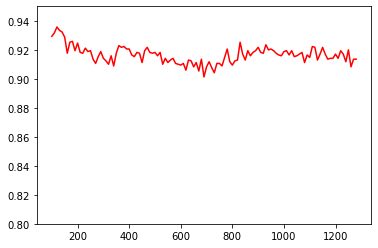

In [14]:
plt.plot(num,S,'r')
plt.ylim(0.8,0.95)
# plt.yticks([0.985,0.990,0.995,1.00])
# plt.xlim(200,1290)
plt.show()

#### 特征选择

In [7]:
#mrmd
# import mRMD
X_ = pd.read_csv('data/process_X.csv')
mrmd_data = run('data/process_X.csv')

mrmd start...
mrmd end.


In [62]:
def MRMD_(X_train,y_train,X_test,y_test):
    clf = ExtraTreesClassifier()
    kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=10)
    avg_score_valid=[]
    scores_test = []
    X = X_train
    Y = y_train
    for train_index, test_index in kf.split(X,Y):
        kf_X_train,kf_X_test=X[train_index],X[test_index]
        kf_y_train,kf_y_test=Y[train_index],Y[test_index]
        clf.fit(kf_X_train,kf_y_train)
        scores_test.append(clf.score(X_test,y_test))
    scores = np.array(scores_test)
    avg_score_test = np.sum(scores)/10
    print("This is validation score: %s" % (avg_score_test))
    return avg_score_test

In [22]:
def cv1(df_X,df_y,n_folds=5):
    eval_dict = []
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=10)#K-折叠交叉验证。
    for train_index, test_index in kf.split(df_X, df_y):
        model= ExtraTreesClassifier(random_state=10)
        X_train,X_test=df_X[train_index],df_X[test_index]
        y_train,y_test=df_y[train_index],df_y[test_index]
        model.fit(X_train,y_train)
        eval_dictionary = evaluate(X_test,y_test,model)
        eval_dict = eval_dict+[eval_dictionary]
    evals = pd.DataFrame(eval_dict).mean()
    Evals = pd.DataFrame(evals)
    return Evals

In [63]:
#前项特征选择(CV model错了)
from sklearn.model_selection import cross_val_score
ET = ExtraTreesClassifier(random_state=10)
# ALL_eval=pd.DataFrame()
S=[]
num = []
for i in range(100,1290,10):
    y_train = X_['label'].to_numpy()
    X_train = X_[mrmd_data[:i+1]]
    X_train1 = np.array(X_train)
    #打乱数据
    np.random.seed(1234)
    idx = np.random.permutation(len(X_train1))
    X_train1 = X_train1[idx]
    y_train = y_train[idx]
    print(X_train1.shape)
    avg_score_test = MRMD_(X_train1,y_train,X_test,y_test)
    S.append(avg_score_test)
    num.append(i+1)
# ALL_eval.columns=num

(2576, 101)


ValueError: X has 1296 features, but ExtraTreeClassifier is expecting 101 features as input.

In [9]:
#Boruta
from boruta import BorutaPy
#打乱数据
np.random.seed(1234)
idx = np.random.permutation(len(X_norm_train_resampled))
X_norm_train = X_norm_train_resampled[idx]
y_norm_train = y_train_resampled[idx]
ET = ExtraTreesClassifier(random_state=10)
feat_selector = BorutaPy(ET, n_estimators='auto', verbose=2, random_state=seed)

In [10]:
feat_selector.fit(X_norm_train,y_norm_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	1296
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	1296
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	1296
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	1296
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	1296
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	1296
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	1296
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	178
Rejected: 	1118
Iteration: 	9 / 100
Confirmed: 	56
Tentative: 	122
Rejected: 	1118
Iteration: 	10 / 100
Confirmed: 	56
Tentative: 	122
Rejected: 	1118
Iteration: 	11 / 100
Confirmed: 	56
Tentative: 	122
Rejected: 	1118
Iteration: 	12 / 100
Confirmed: 	71
Tentative: 	84
Rejected: 	1141
Iteration: 	13 / 100
Confirmed: 	71
Tentative: 	84
Rejected: 	1141
Iteration: 	14 / 100
Confirmed: 	71
Tentative: 	84
Rejected: 	1141
Iteration: 	15 / 100
Confirmed: 	71
Tentative: 	84
Rejected: 	1141
Iteration: 	16 

BorutaPy(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                 colsample_bylevel=1, colsample_bynode=1,
                                 colsample_bytree=1, gamma=0, gpu_id=-1,
                                 importance_type='gain',
                                 interaction_constraints='',
                                 learning_rate=0.300000012, max_delta_step=0,
                                 max_depth=6, min_child_weight=1, missing=nan,
                                 monotone_constraints='()', n_estimators=248,
                                 n_jobs=0, num_parallel_tree=1,
                                 random_state=1197928190, reg_alpha=0,
                                 reg_lambda=1, scale_pos_weight=1, subsample=1,
                                 tree_method='exact', validate_parameters=1,
                                 verbosity=None),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x17A2B0DB040, 

In [89]:
X_norm_filtered_train = feat_selector.transform(X_norm_train_resampled)
X_train_boruta = pd.DataFrame(X_norm_filtered_train)
X_train_boruta.to_csv('Feature_different/X_train_Boruta.csv',index = False)
X_norm_filtered_test = feat_selector.transform(X_test_norm)
X_test_boruta = pd.DataFrame(X_norm_filtered_test)
X_test_boruta.to_csv('Feature_different/X_test_Boruta.csv',index = False)

In [91]:
y_train_ = pd.DataFrame(y_train_resampled)
y_train_.to_csv('Feature_different/y_train.csv',index = False)

In [19]:
# final_features = list()
indexes = np.where(feat_selector.support_ == True)

In [71]:
feat_selector.support_

array([False,  True, False, ..., False, False, False])

In [21]:
np.save('Feature_different/boruta_fea.txt',indexes)
# c = np.load('Feature_different/F_score_fea.txt.npy')

In [11]:
from sklearn.ensemble import ExtraTreesClassifier
ET = ExtraTreesClassifier(random_state=seed)

In [6]:
#F_score
import numpy as np
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
#打乱数据
np.random.seed(1234)
idx = np.random.permutation(len(X_norm_train_resampled))
X_norm_train = X_norm_train_resampled[idx]
y_norm_train = y_train_resampled[idx]

In [7]:
F, pvalues_f = f_classif(X_norm_train,y_norm_train)
k = F.shape[0] - (pvalues_f > 0.05).sum()
print(k)

1024


In [8]:
selector = SelectKBest(f_classif, k=1024) # k => 我们想要选择的变量数
selector.fit(X_norm_train,y_norm_train) # 在训练集上训练

# index_F = selector.fit(X_norm_train,y_norm_train).get_support(indices=True)#得到索引
# transformed_train.shape #(100, 2), 其选择了第三个及第四个变量 

SelectKBest(k=1024)

In [25]:
np.save('Feature_different/F_score_fea.txt',index_F)
# c = np.load('Feature_different/F_score_fea.txt.npy')

In [9]:
transformed_train = selector.transform(X_norm_train_resampled)# 转换训练集
transformed_test = selector.transform(X_test_norm)
# X_F_train = pd.DataFrame(transformed_train)
# X_F_train.to_csv('Feature_different/X_train_Fscore.csv')
# X_F_test = pd.DataFrame(transformed_test)
# X_F_test.to_csv('Feature_different/X_test_Fscore.csv')

In [18]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

#### Simulated Annealing (SA) 基于模拟退火特征选择

In [103]:
from GA import Genetic_Algorithm # 导入模块
import numpy as np
import random

#打乱数据
np.random.seed(1234)
idx = np.random.permutation(len(X_norm_train_resampled))
X_norm_train = X_norm_train_resampled[idx]
y_norm_train = y_train_resampled[idx]


In [104]:
X_norm_train_set = X_norm_train[0:1036,:]
val_set = X_norm_train[1036:1296,:]
y_norm_train_set = y_norm_train[0:1036]
val_y = y_norm_train[1036:1296]

In [105]:
random.seed()
np.random.seed()
from sklearn.ensemble import ExtraTreesClassifier
ET = ExtraTreesClassifier(random_state=seed)
from sklearn.metrics import log_loss
GA = Genetic_Algorithm(loss_func = log_loss, estimator = ET, 
                             n_gen = 100, n_pop = 15, predict_type = 'predict_proba')
GA.fit(X_train = X_norm_train_set, y_train = y_norm_train_set, X_val = val_set, 
             y_val = val_y, stop_point = 15) 

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:17<00:00,  3.17s/it]


In [106]:
GA_train = GA.transform(X_norm_train_resampled)  # 转换训练集
X_GA_train = pd.DataFrame(GA_train)
GA_test = GA.transform(X_test_norm)  # 转换测试集
X_GA_test = pd.DataFrame(GA_test)
X_GA_train.to_csv('Feature_different/X_train_GA.csv')
X_GA_test.to_csv('Feature_different/X_test_GA.csv')

In [108]:
print(GA.best_loss) # 返回最优特征子集对应的损失

(0.0942,)


In [109]:
X_GA_train

,0,1,2,3,4,5,6,7,8,9,...,632,633,634,635,636,637,638,639,640,641
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.070050,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.194444,0.000000,0.000000,0.000000,0.000000,0.583333,0.000000
1,0.040784,0.000000,0.142268,0.244437,0.066610,0.065643,0.073295,0.102683,0.077422,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.209524,0.238730,0.071429,0.000000,0.100000,0.000000
2,0.000000,0.082704,0.000000,0.000000,0.259452,0.170457,0.095164,0.133320,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.154002,0.000000,0.000000,0.090818,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.269231,0.000000
4,0.046593,0.145541,0.000000,0.139625,0.000000,0.074992,0.000000,0.000000,0.088449,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2557,0.000000,0.020588,0.076577,0.394711,0.021529,0.173158,0.078904,0.254270,0.095859,0.201241,...,0.000000,0.000000,0.000000,0.025972,0.000000,0.093004,0.000000,0.048697,0.116873,0.000000
2558,0.000000,0.072359,0.000000,0.000000,0.075666,0.309715,0.036822,0.116644,0.082869,0.093912,...,0.043447,0.017379,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2559,0.045034,0.000000,0.060368,0.000000,0.056529,0.077869,0.000000,0.113383,0.065705,0.000000,...,0.000000,0.000000,0.000000,0.087154,0.158122,0.000000,0.078947,0.138158,0.221053,0.017968
2560,0.097397,0.024469,0.224524,0.000000,0.159071,0.214864,0.000000,0.039444,0.184891,0.000000,...,0.000000,0.000000,0.030099,0.028092,0.087359,0.000000,0.029782,0.065564,0.010312,0.000000


In [82]:
indexes_GA = np.where(np.array(selector.best_sol)== True)

In [84]:
np.save('Feature_different/GA_fea.txt',indexes_GA)

#### 互信息

In [ ]:
X = pd.read_csv('data/')

In [7]:
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

In [8]:
def udf_MI(X, y):
    result = mutual_info_classif(X, y, n_neighbors = 5) # 用户可以输入想要的临近数
    return result

In [6]:
np.random.seed(1234)
idx = np.random.permutation(len(X_norm_train_resampled))
X_norm_train = X_norm_train_resampled[idx]
y_norm_train = y_train_resampled[idx]

In [11]:
score = udf_MI(X_norm_train,y_norm_train)
sco_mean = score.mean()
k = score.shape[0] - (score <= sco_mean).sum()
print(k)

In [30]:
selector_MI = SelectKBest(udf_MI, k=515) # k => 我们想要选择的变量数
selector_MI.fit(X_norm_train,y_norm_train) # 在训练集上训练
MI_transformed_test = selector_MI.transform(X_test_norm)
MI_transformed_train = selector_MI.transform(X_norm_train_resampled) # 转换训练集

In [1]:
X_MI_train = pd.DataFrame(MI_transformed_train)
X_MI_train.to_csv('Feature_different/X_train_MI.csv',index = False)
X_MI_test = pd.DataFrame(MI_transformed_test)
X_MI_test.to_csv('Feature_different/X_test_MI.csv',index = False)

NameError: name 'pd' is not defined

In [7]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
sfm = SelectFromModel(ExtraTreesClassifier(n_estimators=100,random_state=10),threshold = 'median')

In [8]:
sfm.fit(X_norm_train,y_norm_train)
SFM_transformed_train = sfm.transform(X_norm_train_resampled)
SFM_transformed_test = sfm.transform(X_test_norm)

In [9]:
X_SFM_train = pd.DataFrame(SFM_transformed_train)
X_SFM_train.to_csv('Feature_different/X_train_SFM.csv')
X_SFM_test = pd.DataFrame(SFM_transformed_test)
X_SFM_test.to_csv('Feature_different/X_test_SFM.csv')

[ True  True  True ... False False False]


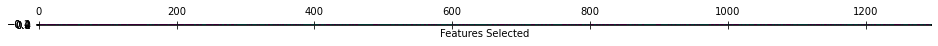

In [10]:
mask_sfm = sfm.get_support()
print(mask_sfm)
plt.matshow(mask_sfm.reshape(1,-1),cmap=plt.cm.cool)
plt.xlabel('Features Selected')
plt.show()

In [11]:
SFM_transformed_train.shape

(2562, 648)

In [12]:
from sklearn.feature_selection import RFE
rfe = RFE(ExtraTreesClassifier(n_estimators=100,random_state=10),n_features_to_select=648)

In [13]:
rfe.fit(X_norm_train,y_norm_train)
RFE_transformed_train = rfe.transform(X_norm_train_resampled)
RFE_transformed_test = rfe.transform(X_test_norm)

In [14]:
X_RFE_train = pd.DataFrame(RFE_transformed_train)
X_RFE_train.to_csv('Feature_different/X_train_RFE.csv')
X_RFE_test = pd.DataFrame(RFE_transformed_test)
X_RFE_test.to_csv('Feature_different/X_test_RFE.csv')